In [1]:
import pennylane as qml
import pennylane.numpy as np
import torch
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim import Adam, Adagrad
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split

import os
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
EPOCHS = 10
SEED = 16
TRAINSIZE = 10000
VALSIZE = 1000
TESTSIZE = 1000

In [3]:
from QCNN_circuit_only import QCNN
from ansatz import ConvCirc1, PoolingCirc

qcnn = QCNN(n_qubits=5, conv_ansatz=ConvCirc1(), pooling_ansatz=PoolingCirc(), stride=1)

dev = qml.device('default.qubit', wires=qcnn.total_qubit)

@qml.qnode(dev, interface='torch')
def circuit(params, data):
    qcnn.construct_circuit(params, data)
    return qml.expval(qml.PauliZ(0))


In [4]:
from datasetloading import TrainTestLoader

In [5]:
loader = TrainTestLoader('./mnist_train.csv', './mnist_test.csv')
loader.scale_pca(n_dim=30)
training_set, test_set = loader.return_dataset()
training_set.filter([0, 1])
test_set.filter([0,1])
training_set, validation_set = random_split(training_set, [TRAINSIZE, len(training_set)-TRAINSIZE], generator=torch.Generator().manual_seed(SEED))
validation_set, _ = random_split(validation_set, [VALSIZE, len(validation_set)-VALSIZE], generator=torch.Generator().manual_seed(SEED))
test_set, _ = random_split(test_set, [TESTSIZE, len(test_set)-TESTSIZE], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for test
training_loader = DataLoader(training_set, batch_size=25, shuffle=True, generator=torch.Generator().manual_seed(SEED))
validation_loader = DataLoader(validation_set, batch_size=25, shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_set, batch_size=25, shuffle=False, generator=torch.Generator().manual_seed(SEED))

# ====================================

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('validation set has {} instances'.format(len(validation_set)))
print('test set has {} instances'.format(len(test_set)))

Training set has 10000 instances
validation set has 1000 instances
test set has 1000 instances


In [6]:
loss_fn = MSELoss() # TODO: choose loss function
params = torch.rand(qcnn.Calculate_Param_Num(), requires_grad=True) # TODO: choose params length

optimizer = Adam([params], lr=0.01) # TODO: choose optimizer
def estimated_label(params, data,Is_print=False):
    if Is_print:
        drawer=qml.draw(circuit)
        print(drawer(params,data))
    return circuit(params, data) # TODO: customize your extimated label
# draw circuit
inputs=next(iter(training_loader))
inputs=inputs[0]
data=inputs[0]
with torch.no_grad():
    estimated_label(params,data,True)

0: ─╭AmplitudeEmbedding(M0)──RY(0.09)─╭C──RY(0.66)────╭X─╭RY(0.48)────╭RY(0.79)──RY(0.25)─╭C
1: ─├AmplitudeEmbedding(M0)──RY(0.13)─╰X──RY(0.32)─╭C─│──╰C─────────X─╰C─────────X────────│─
2: ─├AmplitudeEmbedding(M0)──RY(0.54)─╭C──RY(0.35)─╰X─│──╭RY(0.19)────╭RY(0.32)──RY(0.65)─╰X
3: ─├AmplitudeEmbedding(M0)──RY(0.50)─╰X──RY(0.33)─╭C─│──╰C─────────X─╰C─────────X──────────
4: ─╰AmplitudeEmbedding(M0)──RY(0.19)─╭C──RY(0.75)─╰X─│──╭RY(0.84)────╭RY(0.25)──RY(0.27)─╭C
5: ──RY(0.84)─────────────────────────╰X──RY(0.28)────╰C─╰C─────────X─╰C─────────X────────│─
6: ──RY(0.65)─────────────────────────────────────────────────────────────────────────────╰X

───RY(0.68)────╭X─╭RY(0.98)────╭RY(0.96)──RY(0.22)─╭C──RY(0.04)─╭X─╭RY(0.74)────╭RY(0.82)────┤  <Z>
───────────────│──│────────────│───────────────────│────────────│──│────────────│────────────┤     
───RY(0.43)─╭C─│──╰C─────────X─╰C─────────X────────│────────────│──│────────────│────────────┤     
────────────│──│────────────────────────────────

In [7]:
from tqdm.notebook import tqdm
import logging
import datetime

filepath = './experiment_results'
if os.path.exists(filepath) == False:
    os.makedirs(filepath)


writer = SummaryWriter(log_dir='./runs')

loss_list = []
avg_loss_list = []
avg_vloss_list = []
history_of_parameters = []
for epoch in range(EPOCHS):
    avg_loss = 0.0
    for i, data in tqdm(enumerate(training_loader), total=len(training_loader), desc=f"{epoch+1}"):
        inputs, labels = data
        optimizer.zero_grad()
        loss = torch.tensor(0, dtype=torch.float64)
        for input, label in zip(inputs, labels):
            output = estimated_label(params, input.to(torch.float64))
            loss+=loss_fn(output, 2*label.to(torch.float64)-1)/len(labels)
        loss.backward()       
        optimizer.step()
        avg_loss += loss.item()
        loss_list.append(loss.item())
        writer.add_scalar('local training loss', loss.item(), epoch*len(training_loader)+i)
        np.save(filepath+'/'+f'epoch{epoch}_iter{epoch*len(training_loader)+i}', params.detach().numpy())
        # logger.debug("epoch: {} batch_index: {} --- loss: {} \t params: {}".format(epoch+1, i+1, loss.item(), params.detach().numpy()))


    avg_loss = avg_loss/len(training_loader)
    avg_loss_list.append(avg_loss)
    
    
    with torch.no_grad():
        avg_vloss = 0.0
        for i, vdata in enumerate(validation_loader):
            vloss = torch.tensor(0, dtype=torch.float64)
            vinputs, vlabels = vdata
            for vinput, vlabel in zip(vinputs, vlabels):
                voutput = estimated_label(params, vinput.to(torch.float64))
                vloss += loss_fn(voutput, 2*vlabel.to(torch.float64)-1)/len(vlabels)
            avg_vloss += vloss.item()
        avg_vloss = avg_vloss/len(validation_loader)
        avg_vloss_list.append(avg_vloss)
        history_of_parameters.append(params.numpy())
        np.save(filepath+'/'+f'vaidataion_epoch{epoch}', params.numpy())
    # print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and test
    writer.add_scalar('validation Loss', avg_vloss, epoch)
    writer.flush()
        # print('{}: {}'.format(i, loss.item()))


1:   0%|          | 0/400 [00:00<?, ?it/s]

c:\Users\KimDongHa\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:240.)
  Variable._execution_engine.run_backward(


2:   0%|          | 0/400 [00:00<?, ?it/s]

3:   0%|          | 0/400 [00:00<?, ?it/s]

4:   0%|          | 0/400 [00:00<?, ?it/s]

5:   0%|          | 0/400 [00:00<?, ?it/s]

6:   0%|          | 0/400 [00:00<?, ?it/s]

7:   0%|          | 0/400 [00:00<?, ?it/s]

8:   0%|          | 0/400 [00:00<?, ?it/s]

9:   0%|          | 0/400 [00:00<?, ?it/s]

10:   0%|          | 0/400 [00:00<?, ?it/s]

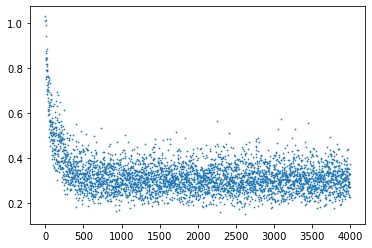

In [8]:
from matplotlib import pyplot as plt
x=range(len(loss_list))
plt.scatter(x,loss_list,s=0.5)

In [9]:
with torch.no_grad():
    est_labels = []
    true_labels = []
    for i, data in enumerate(test_loader):
        test_datas, labels = data
        for label, test_data in zip(labels, test_datas):
            est_labels.append(estimated_label(params, test_data).numpy()>0)
            true_labels.append(label.numpy())

    accuracy = sum(np.array(est_labels)==np.array(true_labels))/len(est_labels)
    accuracy = accuracy.item()
    print(accuracy)

0.974


In [10]:
import json

with open(filepath+'/'+'summary.json', 'w') as fp:
    json.dump(dict(
        accuracy=accuracy,
        loss=loss_list,
        avg_loss = avg_loss_list,
        avg_vloss = avg_vloss_list,
    ), fp=fp)